# Import Required Libraries

In [1]:
import os
import sys
sys.path.append(os.path.abspath(r'/Users/fuchuenli/Desktop/Data Science /Year 2/Trimester 2/COMP SCI 7097/GP-SHAP/Shapley Prior'))
sys.path.append(os.path.abspath(r'/Users/fuchuenli/Desktop/Data Science /Year 2/Trimester 2/COMP SCI 7097/RKHS-SHAP'))

In [2]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import pandas as pd
import seaborn as sns

from gpytorch.kernels import RBFKernel
from sklearn.datasets import load_diabetes
import matplotlib.pylab as plt
from gpytorch.lazy import lazify

from src.gp_model.VariationalGPRegression import VariationalGPRegression
from src.explanation_algorithms.BayesGPSHAP import BayesGPSHAP
from src.predictive_explanation.ShapleyPrior import ShapleyPrior
from src.utils.visualisation import summary_plot
from src.predictive_explanation.ShapleyKernel import ShapleyKernel
from sklearn.datasets import fetch_california_housing
from math import comb

import fastshap
import time

In [3]:
import os, sys, pickle, warnings, torch, shap

import numpy as np
from experiments.BananaShapley.banana_distribution import Banana2d
from experiments.BananaShapley.gshap_banana import Observation2dBanana

warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, pairwise_distances, r2_score
import copy

In [4]:
import torch
import torch.nn as nn
from fastshap.utils import MaskLayer1d
from fastshap import Surrogate, KLDivLoss
from fastshap import FastSHAP

In [5]:
import shap

# Create the Artificial Data and the Predictive Model

In [6]:
n = 1000
v = 10
b = 0.1
iterations = 10
result = []

banana2d = Banana2d(n=n, v=v, b=b, noise=0, outlier_quantile=2.)

# Scaled the output so that can we compare accuracy across
scale = 1
y = torch.Tensor(banana2d.y/scale)
X = torch.Tensor(banana2d.X)
d = X.shape[1]

compute_mh = lambda X: np.array([np.median(pairwise_distances(X[:, [i]])) for i in range(X.shape[1])])
lengthscale = torch.tensor(compute_mh(X)).float()
lengthscale[1] *= 1
print("Lengthscale:", lengthscale)

# True OSVs:
phi1 = banana2d.phi_1/scale
phi2 = banana2d.phi_2/scale
PHI = np.array([phi1, phi2]).T

# # True ISVs:
# phi1_I = banana2d.phi_1_I
# phi2_I = banana2d.phi_2_I
# PHI_I = np.array([phi1_I, phi2_I]).T

Lengthscale: tensor([2.7948, 1.2288])


In [7]:
cutting_points = 700

X_train = X[:cutting_points]
y_train = y[:cutting_points]
X_test = X[cutting_points:]
y_test = y[cutting_points:]

PHI_train = PHI[:cutting_points]
PHI_test = PHI[cutting_points:]

In [8]:
kernel = RBFKernel
gp_regression = VariationalGPRegression(
    X_train, y_train, kernel=kernel, num_inducing_points=200, batch_size=128)

gp_regression.fit(learning_rate=1e-2,
                  training_iteration=300)

Epoch:   0%|          | 0/300 [00:00<?, ?it/s]

## Fast-SHAP

In [9]:
surr = nn.Sequential(
    MaskLayer1d(value=0, append=True),
    nn.Linear(2 * d, 128),
    nn.ELU(inplace=True),
    nn.Linear(128, 128),
    nn.ELU(inplace=True),
    nn.Linear(128, 1)
)

surrogate = Surrogate(surr, d)

def original_model(x):
    return gp_regression.predict(x).mean.detach().reshape(-1, 1).float()

surrogate.train_original_model(
    X_train,
    X_test,
    original_model,
    batch_size=64,
    max_epochs=1000,
    loss_fn=nn.MSELoss(),
    validation_samples=100,
    validation_batch_size=10000,
    verbose=True
)

----- Epoch = 1 -----
Val loss = 2.2124

New best epoch, loss = 2.2124

----- Epoch = 2 -----
Val loss = 1.9424

New best epoch, loss = 1.9424

----- Epoch = 3 -----
Val loss = 1.8091

New best epoch, loss = 1.8091

----- Epoch = 4 -----
Val loss = 1.7357

New best epoch, loss = 1.7357

----- Epoch = 5 -----
Val loss = 1.7059

New best epoch, loss = 1.7059

----- Epoch = 6 -----
Val loss = 1.7124

----- Epoch = 7 -----
Val loss = 1.7083

----- Epoch = 8 -----
Val loss = 1.7179

Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.
----- Epoch = 9 -----
Val loss = 1.7101

----- Epoch = 10 -----
Val loss = 1.6957

New best epoch, loss = 1.6957

----- Epoch = 11 -----
Val loss = 1.6977

----- Epoch = 12 -----
Val loss = 1.6888

New best epoch, loss = 1.6888

----- Epoch = 13 -----
Val loss = 1.6869

New best epoch, loss = 1.6869

----- Epoch = 14 -----
Val loss = 1.6896

----- Epoch = 15 -----
Val loss = 1.6778

New best epoch, loss = 1.6778

----- Epoch = 16 -----
Val loss = 1.67

In [10]:
explainer = nn.Sequential(
    nn.Linear(d, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 128),
    nn.ReLU(inplace=True),
    nn.Linear(128, 2 * d))

# Set up FastSHAP object
fastshap = FastSHAP(explainer, surrogate, normalization='additive')

# Train
fastshap.train(
    X_train,
    X_test,
    batch_size=32,
    num_samples=32,
    max_epochs=1000,
    validation_samples=100,
    verbose=True)

----- Epoch = 1 -----
Val loss = 0.804921

New best epoch, loss = 0.804921

----- Epoch = 2 -----
Val loss = 0.626301

New best epoch, loss = 0.626301

----- Epoch = 3 -----
Val loss = 0.498067

New best epoch, loss = 0.498067

----- Epoch = 4 -----
Val loss = 0.395428

New best epoch, loss = 0.395428

----- Epoch = 5 -----
Val loss = 0.309759

New best epoch, loss = 0.309759

----- Epoch = 6 -----
Val loss = 0.245186

New best epoch, loss = 0.245186

----- Epoch = 7 -----
Val loss = 0.200205

New best epoch, loss = 0.200205

----- Epoch = 8 -----
Val loss = 0.177549

New best epoch, loss = 0.177549

----- Epoch = 9 -----
Val loss = 0.167185

New best epoch, loss = 0.167185

----- Epoch = 10 -----
Val loss = 0.163292

New best epoch, loss = 0.163292

----- Epoch = 11 -----
Val loss = 0.162669

New best epoch, loss = 0.162669

----- Epoch = 12 -----
Val loss = 0.161168

New best epoch, loss = 0.161168

----- Epoch = 13 -----
Val loss = 0.159871

New best epoch, loss = 0.159871

----- Ep

In [11]:
# fastshap predictions
fastshap_preds = [fastshap.shap_values(X_test[i:i+1])[0].mean(axis=1) for i in range(X.shape[0] - cutting_points)]
fastshap_preds = torch.tensor(fastshap_preds)

In [12]:
fastshap_mse = mean_squared_error(y_true=PHI_test, y_pred=fastshap_preds)
fastshap_mse

0.268930329083249

## Shapley Prior

In [13]:
bayesgpshap = BayesGPSHAP(train_X=X, kernel=RBFKernel(), gp_model=gp_regression,
                          include_likelihood_noise_for_explanation=False, scale=scale)

In [14]:
bayesgpshap.run_bayesSHAP(X=X, num_coalitions=2**d)
explanations = bayesgpshap.mean_shapley_values

100%|██████████| 3/3 [00:00<00:00, 449.50it/s]


In [15]:
target = explanations.t().reshape(-1, 1)
shapley_kernel = ShapleyKernel(
    train_X=X, kernel=RBFKernel(), lengthscales=gp_regression.lengthscale, 
    inducing_points=gp_regression.inducing_points,
    num_coalitions=2**d, sampling_method="subsampling", verbose=False
)

target_train = target[:cutting_points*d]

optim = torch.optim.Adam(shapley_kernel.parameters(), lr=1e-3)
def loss_function(pred, true):
    return torch.mean((true - pred) **2)

min_loss = np.inf
early_stopping = 0
while True:
    optim.zero_grad()
    Psi = shapley_kernel(X)
    K = torch.einsum("ijk,lmn->imkn", Psi, Psi.transpose(0, 1))
    K = K.permute(2, 0, 3, 1).resize(len(target), len(target))
    K_train = K[:cutting_points*d, :cutting_points*d]
    prediction = K_train @ lazify(K_train).add_diag(shapley_kernel.krr_regularisation).inv_matmul(target_train)
    loss = loss_function(prediction, target_train)
    print(loss)
    loss.backward()
    optim.step()
    if loss >= min_loss:
        early_stopping += 1
    else:
        min_loss = loss
        early_stopping = 0
        
    if early_stopping >= 20:
        break


tensor(1.6927, grad_fn=<MeanBackward0>)
tensor(1.6897, grad_fn=<MeanBackward0>)
tensor(1.6867, grad_fn=<MeanBackward0>)
tensor(1.6836, grad_fn=<MeanBackward0>)
tensor(1.6807, grad_fn=<MeanBackward0>)
tensor(1.6774, grad_fn=<MeanBackward0>)
tensor(1.6746, grad_fn=<MeanBackward0>)
tensor(1.6714, grad_fn=<MeanBackward0>)
tensor(1.6681, grad_fn=<MeanBackward0>)
tensor(1.6646, grad_fn=<MeanBackward0>)
tensor(1.6614, grad_fn=<MeanBackward0>)
tensor(1.6579, grad_fn=<MeanBackward0>)
tensor(1.6543, grad_fn=<MeanBackward0>)
tensor(1.6510, grad_fn=<MeanBackward0>)
tensor(1.6474, grad_fn=<MeanBackward0>)
tensor(1.6438, grad_fn=<MeanBackward0>)
tensor(1.6397, grad_fn=<MeanBackward0>)
tensor(1.6359, grad_fn=<MeanBackward0>)
tensor(1.6318, grad_fn=<MeanBackward0>)
tensor(1.6277, grad_fn=<MeanBackward0>)
tensor(1.6237, grad_fn=<MeanBackward0>)
tensor(1.6193, grad_fn=<MeanBackward0>)
tensor(1.6149, grad_fn=<MeanBackward0>)
tensor(1.6105, grad_fn=<MeanBackward0>)
tensor(1.6056, grad_fn=<MeanBackward0>)


In [16]:
Psi = shapley_kernel(X)
K = torch.einsum("ijk,lmn->imkn", Psi, Psi.transpose(0, 1))
K = K.permute(2, 0, 3, 1).resize(len(target), len(target))

K_train = K[:cutting_points*d, :cutting_points*d]
K_test_train = K[cutting_points*d:, :cutting_points*d]

train_target = target[:cutting_points*d]
test_target = target[cutting_points*d:]

pred = K_test_train @ lazify(K_train).add_diag(shapley_kernel.krr_regularisation).inv_matmul(train_target)
pred = pred.reshape((-1, 2)).detach().numpy()

In [17]:
shapley_prior_mse = mean_squared_error(y_true=PHI_test, y_pred=pred)
shapley_prior_mse

0.25921619869550483

## KernelSHAP

In [18]:
# Assume this is your custom model class
class CustomModel:
    def predict_custom(self, data):
        # Your prediction logic here
        pred = []
        for i in range(data.shape[0]):
            pred.append(gp_regression.predict(torch.Tensor(data[i]).reshape((1,d))).loc.item())
        return np.array(pred)

# Create an instance of your model
model = CustomModel()

# Define a wrapper function for the model's prediction
def model_predict(data):
    return model.predict_custom(data)

In [19]:
# # Say you have some training data X_train and you want to explain predictions on X_test
# background_data = X_train
# explainer = shap.KernelExplainer(model_predict, X.numpy())

# # Compute SHAP values for a specific instance (or multiple instances)
# shap_values = explainer.shap_values(X_test.numpy())

# # Now you can visualize or analyze the SHAP values as needed


In [20]:
# mean_squared_error(y_true=PHI_test, y_pred=shap_values)

In [21]:
ogshap = Observation2dBanana(model_predict, X_test.numpy())
ophi1, ophi2 = ogshap.fit(X_test, num_samples=X_test.shape[0])    
OPHI = np.array([ophi1,ophi2]).T

100%|██████████| 258/258 [01:11<00:00,  3.63it/s]


In [22]:
gshap_mse = mean_squared_error(y_true=PHI_test, y_pred=OPHI)
gshap_mse

200.6483928923114

## Evaluation

<Axes: xlabel='SHAP', ylabel='MSE'>

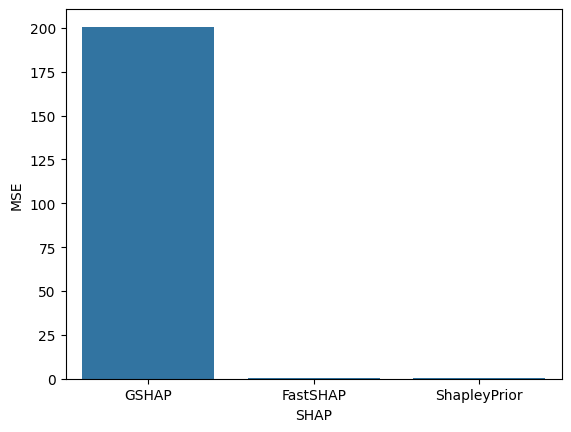

In [23]:
results = pd.DataFrame({"SHAP": ["GSHAP", "FastSHAP", "ShapleyPrior"], "MSE": [gshap_mse, fastshap_mse, shapley_prior_mse]})
sns.barplot(x="SHAP", y="MSE", data=results)